In [1]:
# basic dependencies

import numpy as np
from numpy import loadtxt
from numpy import savetxt

import pandas as pd
import math
import time

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

###########

# torch dependencies
import torch

tkwargs = {"dtype": torch.double, # set as double to minimize zero error for cholesky decomposition error
           "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")} # set tensors to GPU, if multiple GPUs please set cuda:x properly

torch.set_printoptions(precision=3)

###########

# botorch dependencies
import botorch

# data related
#from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import unnormalize, normalize

# surrogate model specific
from botorch.models.gp_regression import SingleTaskGP, FixedNoiseGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch import fit_gpytorch_model

# qNEHVI specific
from botorch.acquisition.multi_objective.objective import IdentityMCMultiOutputObjective
from botorch.acquisition.multi_objective.monte_carlo import qNoisyExpectedHypervolumeImprovement

# qNParEGO specific
from botorch.acquisition.objective import GenericMCObjective, ConstrainedMCObjective
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch.utils.sampling import sample_simplex

# utilities
from botorch.optim.optimize import optimize_acqf, optimize_acqf_list
#from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume
from botorch.utils.multi_objective.hypervolume import infer_reference_point
from typing import Optional
from torch import Tensor
from botorch.exceptions import BadInitialCandidatesWarning

import warnings

warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

###########

# pymoo dependencies
import pymoo

from pymoo.factory import get_problem
from pymoo.core.problem import ElementwiseProblem

from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.moo.unsga3 import UNSGA3
from pymoo.algorithms.moo.ctaea import CTAEA
from pymoo.factory import get_sampling, get_crossover, get_mutation, get_reference_directions, get_termination
from pymoo.optimize import minimize

from pymoo.core.problem import Problem
#from pymoo.util.termination.no_termination import NoTermination
#from pymoo.core.evaluator import set_cv
#from pymoo.factory import get_performance_indicator

###########

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern, WhiteKernel
from sklearn.preprocessing import MinMaxScaler

from scipy.stats import qmc
from scipy.stats import gaussian_kde # for density plot

###########

# plotting dependencies
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# this is for the colorbar, you can change the cmap if you prefer other colour schemes
from matplotlib.cm import ScalarMappable
cm = plt.cm.get_cmap('viridis')

# function to return the std dev across runs
def ci(y, N_TRIALS):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

from matplotlib.ticker import FormatStrFormatter

C:\Users\user\AppData\Local\Temp\ipykernel_19492\4240570951.py:101: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('viridis')


In [10]:
def optimize_qnehvi(problem, ref_point, initial_x, # must haves
                    N_BATCH, BATCH_SIZE, 
                    random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with qNEHVI")

    t0 = time.time()

    # some initializing 
    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj, train_con = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    train_con_noisy = train_con + noise*torch.randn_like(train_con)
    
    ##########
    
    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, problem.bounds)
    
    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
        
    ##########    
    
    def create_idxr(i):
        def idxr(Z):
            return Z[..., i]

        return idxr

    def create_idxrs():
        return [create_idxr(i=i) for i in range(problem.n_obj, problem.n_obj+problem.n_constr)]
    
    # original location for an extra HV check wrt to initial samples
    
    ########## ########## ########## start of iteration loop


    # training loop for N_BATCH iterations
    for iteration in range(1, N_BATCH + 1):    

        t3 = time.time()
                
        # fit the surrogate model
        fit_gpytorch_model(mll)    
                
        ##########
            
        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=-ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(num_samples=128),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            constraints=create_idxrs(), # constraint on last n_constr col
            prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on
        
        ##########
        
        # propose candidates given defined qNEHVI acq func given model and latest observed training data
        new_x, _ = optimize_acqf(
                        acq_function=acq_func,
                        bounds=standard_bounds, # since train_x was normalized
                        q=BATCH_SIZE, # no of candidates to propose in parallel
                        num_restarts=2, # no of restarts if q candidates fail to show improvement
                        raw_samples=128,  # pool of samples to choose the starting points from
                        options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                        )

        # unormalize our training inputs back to original problem bounds
        new_x =  unnormalize(new_x.detach(), bounds=problem.bounds)

        # feed new proposed observations into objective func to get its new ground truth
        new_obj, new_con = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)
        new_con_noisy = new_con + noise*torch.randn_like(new_con)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_con = torch.cat([train_con, new_con])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
        train_con_noisy = torch.cat([train_con_noisy, new_con_noisy])
        
        ##########
        
        # computing HV of current candidate list
        is_feas = (train_con <= 0).all(dim=-1) # check whether points fit ALL (.all) constraint criteria
        feas_train_obj = train_obj[is_feas] # take only points that fit the 1st check
        if feas_train_obj.shape[0] > 0:
            pareto_mask = is_non_dominated(feas_train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
            pareto_y = feas_train_obj[pareto_mask] # take only points that fit the 2nd check
            volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        else:
            volume = 0.0
        
        hvs.append(volume)
        
        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)
        
        ##########
        
        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")
            
        del new_x, new_obj, new_con, new_obj_noisy, new_con_noisy, train_x_gp, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial     
        
        ########## ########## ########## end of iteration loop

    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")       
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj, train_con]).cpu().numpy()

def optimize_qnehvi_noconstr(problem, ref_point, initial_x, # must haves
                    N_BATCH, BATCH_SIZE, 
                    random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with qNEHVI")

    t0 = time.time()

    # some initializing 
    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    
    ##########
    
    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, problem.bounds)
    
    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = train_obj_noisy

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
        
    ##########    
    
    # original location for an extra HV check wrt to initial samples
    
    ########## ########## ########## start of iteration loop


    # training loop for N_BATCH iterations
    for iteration in range(1, N_BATCH + 1):    

        t3 = time.time()
                
        # fit the surrogate model
        fit_gpytorch_model(mll)    
                
        ##########
            
        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=-ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(num_samples=128),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on
        
        ##########
        
        # propose candidates given defined qNEHVI acq func given model and latest observed training data
        new_x, _ = optimize_acqf(
                        acq_function=acq_func,
                        bounds=standard_bounds, # since train_x was normalized
                        q=BATCH_SIZE, # no of candidates to propose in parallel
                        num_restarts=2, # no of restarts if q candidates fail to show improvement
                        raw_samples=128,  # pool of samples to choose the starting points from
                        options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                        )

        # unormalize our training inputs back to original problem bounds
        new_x =  unnormalize(new_x.detach(), bounds=problem.bounds)

        # feed new proposed observations into objective func to get its new ground truth
        new_obj = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
        
        ##########
        
        # computing HV of current candidate list
        pareto_mask = is_non_dominated(train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
        pareto_y = train_obj[pareto_mask] # take only points that fit the 2nd check
        volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        
        hvs.append(volume)
        
        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = train_obj_noisy

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)
        
        ##########
        
        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")
            
        del new_x, new_obj, new_obj_noisy, train_x_gp, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial     
        
        ########## ########## ########## end of iteration loop

    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")       
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj]).cpu().numpy()

In [11]:
def optimize_qnparego(problem, ref_point, initial_x, # must haves
                    N_BATCH, BATCH_SIZE, 
                    random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with qNParEGO")

    t0 = time.time()

    # some initializing 
    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj, train_con = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    train_con_noisy = train_con + noise*torch.randn_like(train_con)
    
    ##########
    
    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, problem.bounds)
    
    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
        
    ##########    
    
    def get_constrained_mc_objective(train_obj, train_con, scalarization):
        """Initialize a ConstrainedMCObjective for qParEGO"""
        n_obj = train_obj.shape[-1]
        # assume first outcomes of the model are the objectives, the rest constraints
        def objective(Z):
            return scalarization(Z[..., :n_obj])

        constrained_obj = ConstrainedMCObjective(
            objective=objective,
            constraints=[lambda Z: Z[..., -1]],  # index the constraint
        )
        return constrained_obj

    
    ########## ########## ########## start of iteration loop


    # training loop for N_BATCH iterations
    for iteration in range(1, N_BATCH + 1):    

        t3 = time.time()
                
        # fit the surrogate model
        fit_gpytorch_model(mll)    
                
        ##########
        
        with torch.no_grad():
            pred = model.posterior(normalize(train_x, problem.bounds)).mean
        acq_func_list = []
        for _ in range(BATCH_SIZE):
            weights = sample_simplex(problem.n_obj, **tkwargs).squeeze()
            # construct augmented Chebyshev scalarization
            scalarization = get_chebyshev_scalarization(weights=weights, Y=pred[:,:problem.n_obj])
            # initialize ConstrainedMCObjective
            constrained_objective = get_constrained_mc_objective(
                train_obj=train_obj,
                train_con=train_con,
                scalarization=scalarization,
            )
            acq_func = qNoisyExpectedImprovement(  # pyre-ignore: [28]
                model=model,
                objective=constrained_objective,
                X_baseline=train_x,
                sampler=SobolQMCNormalSampler(num_samples=128),
                prune_baseline=True,
            )
            acq_func_list.append(acq_func)        
            
        new_x, _ = optimize_acqf_list(
                acq_function_list=acq_func_list,
                bounds=standard_bounds,
                num_restarts=2,
                raw_samples=128,  # used for intialization heuristic
                options={"batch_limit": 5, "maxiter": 200},
        )
        
        ##########

        # unormalize our training inputs back to original problem bounds
        new_x =  unnormalize(new_x.detach(), bounds=problem.bounds)

        # feed new proposed observations into objective func to get its new ground truth
        new_obj, new_con = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)
        new_con_noisy = new_con + noise*torch.randn_like(new_con)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_con = torch.cat([train_con, new_con])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
        train_con_noisy = torch.cat([train_con_noisy, new_con_noisy])
        
        ##########
        
        # computing HV of current candidate list
        is_feas = (train_con <= 0).all(dim=-1) # check whether points fit ALL (.all) constraint criteria
        feas_train_obj = train_obj[is_feas] # take only points that fit the 1st check
        if feas_train_obj.shape[0] > 0:
            pareto_mask = is_non_dominated(feas_train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
            pareto_y = feas_train_obj[pareto_mask] # take only points that fit the 2nd check
            volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        else:
            volume = 0.0
        
        hvs.append(volume)
        
        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)
        
        ##########
        
        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")
            
        del new_x, new_obj, new_con, new_obj_noisy, new_con_noisy, train_x_gp, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial     
        
        ########## ########## ########## end of iteration loop

    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")       
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj, train_con]).cpu().numpy()

def optimize_qnparego_noconstr(problem, ref_point, initial_x, # must haves
                    N_BATCH, BATCH_SIZE, 
                    random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with qNParEGO")

    t0 = time.time()

    # some initializing 
    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    
    ##########
    
    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, problem.bounds)
    
    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = train_obj_noisy

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
        
    ##########    
    
    # original location for an extra HV check wrt to initial samples
    
    ########## ########## ########## start of iteration loop


    # training loop for N_BATCH iterations
    for iteration in range(1, N_BATCH + 1):    

        t3 = time.time()
                
        # fit the surrogate model
        fit_gpytorch_model(mll)    
                
        ##########
            
        with torch.no_grad():
            pred = model.posterior(normalize(train_x, problem.bounds)).mean
        acq_func_list = []
        for _ in range(BATCH_SIZE):
            weights = sample_simplex(problem.n_obj, **tkwargs).squeeze()
            objective = GenericMCObjective(get_chebyshev_scalarization(weights=weights, Y=pred))
            acq_func = qNoisyExpectedImprovement(  # pyre-ignore: [28]
                model=model,
                objective=objective,
                X_baseline=train_x,
                sampler=SobolQMCNormalSampler(num_samples=128),
                prune_baseline=True,
            )
            acq_func_list.append(acq_func)  
            
        new_x, _ = optimize_acqf_list(
                acq_function_list=acq_func_list,
                bounds=standard_bounds,
                num_restarts=2,
                raw_samples=128,  # used for intialization heuristic
                options={"batch_limit": 5, "maxiter": 200},
        )

        # unormalize our training inputs back to original problem bounds
        new_x =  unnormalize(new_x.detach(), bounds=problem.bounds)

        # feed new proposed observations into objective func to get its new ground truth
        new_obj = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
        
        ##########
        
        # computing HV of current candidate list
        pareto_mask = is_non_dominated(train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
        pareto_y = train_obj[pareto_mask] # take only points that fit the 2nd check
        volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        
        hvs.append(volume)
        
        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = train_obj_noisy

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)
        
        ##########
        
        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")
            
        del new_x, new_obj, new_obj_noisy, train_x_gp, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial     
        
        ########## ########## ########## end of iteration loop

    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")       
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj]).cpu().numpy()

In [12]:
def optimize_yolo(problem, ref_point, initial_x, # must haves
                    N_BATCH, BATCH_SIZE, 
                    random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with Div-assisted qNEHVI")

    t0 = time.time()

    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    pymooproblem = Problem(n_var=problem.n_var, n_obj=problem.n_obj, n_constr=0, 
                  xl=np.zeros(problem.n_var), xu=np.ones(problem.n_var))

    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj, train_con = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    train_con_noisy = train_con + noise*torch.randn_like(train_con)

    ##########

    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, problem.bounds)

    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    
    ##########    
    
    def create_idxr(i):
        def idxr(Z):
            return Z[..., i]

        return idxr

    def create_idxrs():
        return [create_idxr(i=i) for i in range(problem.n_obj, problem.n_obj+problem.n_constr)]
    
    ########## ########## ########## start of iteration loop

    for iteration in range(1, N_BATCH + 1):   

        t3 = time.time()

        ##########

        fit_gpytorch_model(mll)  

        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=-ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(num_samples=128),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            constraints=create_idxrs(), # constraint on last n_constr col
            prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on

        # propose best candidates given QMC and qNEHVI
        qnehvi_x, _ = optimize_acqf(acq_function=acq_func,
                                    bounds=standard_bounds, # since train_x was normalized
                                    q=8, # no of candidates to propose in parallel, 12 is the max for a GTX1065
                                    num_restarts=2, # no of restarts if q candidates fail to show improvement
                                    raw_samples=128,  # pool of samples to choose the starting points from
                                    options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                                 )

        ##########

        # we pick out the best points so far to form parents
        pareto_mask = is_non_dominated(train_obj_noisy)
        pareto_y = train_obj_noisy[pareto_mask]
        pareto_x = normalize(train_x, problem.bounds)[pareto_mask]
        pareto_con = train_con[pareto_mask]
        
        algorithm = UNSGA3(pop_size=128,
                           ref_dirs=get_reference_directions("energy", problem.n_obj, BATCH_SIZE, seed=random_state),
                           sampling=pareto_x.cpu().numpy(),
                           #crossover=SimulatedBinaryCrossover(eta=30, prob=1.0),
                           #mutation=PolynomialMutation(eta=20, prob=None),
                          )

        algorithm.setup(pymooproblem, termination=NoTermination())

        # set the 1st population to the current evaluated population
        pop = algorithm.ask()
        pop.set("F", pareto_y.cpu().numpy())
        pop.set("G", pareto_con.cpu().numpy())
        set_cv(pop)
        algorithm.tell(infills=pop)

        # propose children based on tournament selection -> crossover/mutation
        newpop = algorithm.ask()
        nsga3_x = torch.tensor(newpop.get("X"), **tkwargs)
        
        ##########

        candidates = torch.cat([qnehvi_x, nsga3_x])

        acq_value_list = []

        for i in range(0, candidates.shape[0]):
            with torch.no_grad():
                acq_value = acq_func(candidates[i].unsqueeze(dim=0))
                acq_value_list.append(acq_value.item())

        pred_hv_list = []
        model.eval();

        for i in range(0, candidates.shape[0]):
            with torch.no_grad():
                posterior = model.posterior(candidates[i].unsqueeze(0))
                pred_y = posterior.mean
                pred_hv = hv.compute(pred_y[:,:problem.n_obj])
                pred_hv_list.append(pred_hv)

        sorted_x = candidates.cpu().numpy()[np.lexsort((pred_hv_list, acq_value_list))]

        ##########
        
        new_x = torch.tensor(sorted_x[-BATCH_SIZE:], **tkwargs) # take best BATCH_SIZE samples
        # unormalize our training inputs back to original problem bounds
        new_x =  unnormalize(new_x.detach(), bounds=problem.bounds)

        # feed new proposed observations into objective func to get its new ground truth
        new_obj, new_con = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)
        new_con_noisy = new_con + noise*torch.randn_like(new_con)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_con = torch.cat([train_con, new_con])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
        train_con_noisy = torch.cat([train_con_noisy, new_con_noisy])

        # computing HV of current candidate list
        is_feas = (train_con <= 0).all(dim=-1) # check whether points fit ALL (.all) constraint criteria
        feas_train_obj = train_obj[is_feas] # take only points that fit the 1st check
        if feas_train_obj.shape[0] > 0:
            pareto_mask = is_non_dominated(feas_train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
            pareto_y = feas_train_obj[pareto_mask] # take only points that fit the 2nd check
            volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        else:
            volume = 0.0

        hvs.append(volume)

        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)

        ##########

        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")

        del new_x, new_obj, new_con, qnehvi_x, nsga3_x, new_obj_noisy, new_con_noisy, train_x_gp, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial    
        
    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")   
    
    del models, model, mll
    torch.cuda.empty_cache() # clear some memory here between each run/trial  
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj, train_con]).cpu().numpy()

def optimize_yolo_noconstr(problem, ref_point, initial_x, # must haves
                    N_BATCH, BATCH_SIZE, 
                    random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with Div-assisted qNEHVI")

    t0 = time.time()

    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    pymooproblem = Problem(n_var=problem.n_var, n_obj=problem.n_obj, n_constr=0, 
                  xl=np.zeros(problem.n_var), xu=np.ones(problem.n_var))

    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)

    ##########

    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, problem.bounds)

    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = train_obj_noisy

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)

    for iteration in range(1, N_BATCH + 1):   

        t3 = time.time()

        ##########

        fit_gpytorch_model(mll)  

        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=-ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(num_samples=128),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on

        # propose best candidates given QMC and qNEHVI
        qnehvi_x, _ = optimize_acqf(acq_function=acq_func,
                                    bounds=standard_bounds, # since train_x was normalized
                                    q=8, # no of candidates to propose in parallel, 12 is the max for a GTX1065
                                    num_restarts=2, # no of restarts if q candidates fail to show improvement
                                    raw_samples=128,  # pool of samples to choose the starting points from
                                    options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                                 )

        ##########

        # we pick out the best points so far to form parents
        pareto_mask = is_non_dominated(train_obj_noisy)
        pareto_y = train_obj_noisy[pareto_mask]
        pareto_x = normalize(train_x, problem.bounds)[pareto_mask]
        
        algorithm = UNSGA3(pop_size=128,
                           ref_dirs=get_reference_directions("energy", problem.n_obj, BATCH_SIZE, seed=random_state),
                           sampling=pareto_x.cpu().numpy(),
                           #crossover=SimulatedBinaryCrossover(eta=30, prob=1.0),
                           #mutation=PolynomialMutation(eta=20, prob=None),
                          )

        algorithm.setup(pymooproblem, termination=NoTermination())

        # set the 1st population to the current evaluated population
        pop = algorithm.ask()
        pop.set("F", pareto_y.cpu().numpy())
        set_cv(pop)
        algorithm.tell(infills=pop)

        # propose children based on tournament selection -> crossover/mutation
        newpop = algorithm.ask()
        nsga3_x = torch.tensor(newpop.get("X"), **tkwargs)
        
        ##########

        candidates = torch.cat([qnehvi_x, nsga3_x])

        acq_value_list = []

        for i in range(0, candidates.shape[0]):
            with torch.no_grad():
                acq_value = acq_func(candidates[i].unsqueeze(dim=0))
                acq_value_list.append(acq_value.item())

        pred_hv_list = []
        model.eval();

        for i in range(0, candidates.shape[0]):
            with torch.no_grad():
                posterior = model.posterior(candidates[i].unsqueeze(0))
                pred_y = posterior.mean
                pred_hv = hv.compute(pred_y)
                pred_hv_list.append(pred_hv)

        sorted_x = candidates.cpu().numpy()[np.lexsort((pred_hv_list, acq_value_list))]

        ##########
        
        new_x = torch.tensor(sorted_x[-BATCH_SIZE:], **tkwargs) # take best BATCH_SIZE samples
        new_x =  unnormalize(new_x, bounds=problem.bounds)
        new_obj = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])

        # computing HV of current candidate list
        pareto_mask = is_non_dominated(train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
        pareto_y = train_obj[pareto_mask] # take only points that fit the 2nd check
        volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point

        hvs.append(volume)

        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = train_obj_noisy

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)

        ##########

        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")

        del new_x, new_obj, qnehvi_x, nsga3_x, new_obj_noisy, train_x_gp, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial    
        
    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")   
    
    del models, model, mll
    torch.cuda.empty_cache() # clear some memory here between each run/trial  
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj]).cpu().numpy()

In [13]:
def optimize_gpcheck(problem, ref_point, initial_x, # must haves
                    N_BATCH, BATCH_SIZE, 
                    random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with qNEHVI")

    t0 = time.time()

    # some initializing 
    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    pf_list = []
    
    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj, train_con = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    train_con_noisy = train_con + noise*torch.randn_like(train_con)
    
    ##########
    
    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, problem.bounds)
    
    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
        
    ##########    
    
    def create_idxr(i):
        def idxr(Z):
            return Z[..., i]

        return idxr

    def create_idxrs():
        return [create_idxr(i=i) for i in range(problem.n_obj, problem.n_obj+problem.n_constr)]
    
    # original location for an extra HV check wrt to initial samples
    
    ########## ########## ########## start of iteration loop


    # training loop for N_BATCH iterations
    for iteration in range(1, N_BATCH + 1):    

        t3 = time.time()
                
        # fit the surrogate model
        fit_gpytorch_model(mll)    
                
        ##########
            
        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=-ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(num_samples=128),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            constraints=create_idxrs(), # constraint on last n_constr col
            prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on
        
        ##########
        
        # propose candidates given defined qNEHVI acq func given model and latest observed training data
        new_x, _ = optimize_acqf(
                        acq_function=acq_func,
                        bounds=standard_bounds, # since train_x was normalized
                        q=BATCH_SIZE, # no of candidates to propose in parallel
                        num_restarts=2, # no of restarts if q candidates fail to show improvement
                        raw_samples=128,  # pool of samples to choose the starting points from
                        options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                        )

        # unormalize our training inputs back to original problem bounds
        new_x =  unnormalize(new_x.detach(), bounds=problem.bounds)

        # feed new proposed observations into objective func to get its new ground truth
        new_obj, new_con = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)
        new_con_noisy = new_con + noise*torch.randn_like(new_con)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_con = torch.cat([train_con, new_con])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
        train_con_noisy = torch.cat([train_con_noisy, new_con_noisy])
        
        ##########
        
        # computing HV of current candidate list
        is_feas = (train_con <= 0).all(dim=-1) # check whether points fit ALL (.all) constraint criteria
        feas_train_obj = train_obj[is_feas] # take only points that fit the 1st check
        if feas_train_obj.shape[0] > 0:
            pareto_mask = is_non_dominated(feas_train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
            pareto_y = feas_train_obj[pareto_mask] # take only points that fit the 2nd check
            volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        else:
            volume = 0.0
        
        hvs.append(volume)
        
        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)
        
        # define a pymoo problem class based on the torch class
        class PymooProblem(ElementwiseProblem):

            def __init__(self):
                super().__init__(n_var=problem.n_var,
                                 n_obj=problem.n_obj,
                                 n_constr=problem.n_constr,
                                 xl=problem.bounds[0].cpu().numpy(),
                                 xu=problem.bounds[1].cpu().numpy())

            def _evaluate(self, X, out, *args, **kwargs):
                # base input/output from torch class
                train_x = torch.tensor(X.tolist(), **tkwargs).unsqueeze(dim=0)

                pred_list = []
                con_list = []
                model.eval();

                for i in range(0, train_x.shape[0]):
                    with torch.no_grad():
                        posterior = model.posterior(train_x[i].unsqueeze(0))
                        pred_y = posterior.mean
                        pred_list.append(pred_y[...,:problem.n_obj].cpu().numpy().squeeze(0).tolist())
                        con_list.append(pred_y[...,problem.n_obj:].cpu().numpy().squeeze(0).tolist())

                # output the noisy observations instead
                out["F"] = -np.array(pred_list) # flip since botorch assumes maximisation vs pymoo minimization
                out["G"] = -np.array(con_list) # flip since botorch assumes maximisation vs pymoo minimization

        ##########        

        pymooproblem = PymooProblem()

        # create the algorithm object
        algorithm = UNSGA3(pop_size=100,
                          ref_dirs=get_reference_directions("energy", problem.n_obj, 100, seed=random_state),
                          sampling=train_x.cpu().numpy()
                         )

        # execute the optimization, take N_BATCH+1 since 1st iteration is just the initial sampling
        res = minimize(pymooproblem, algorithm, seed=random_state, termination=('n_gen', 100+1),
                       verbose=False, save_history=True)

        pf_list.append(res.history[-1].pop.get("F").tolist())        
        
        ##########
        
        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")
            
        del new_x, new_obj, new_con, new_obj_noisy, new_con_noisy, train_x_gp, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial     
        
        ########## ########## ########## end of iteration loop

    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")       
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj, train_con]).cpu().numpy(), pf_list

In [14]:
def optimize_gpcheck_noconstr(problem, ref_point, initial_x, # must haves
                    N_BATCH, BATCH_SIZE, 
                    random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with qNEHVI")

    t0 = time.time()

    # some initializing 
    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    pf_list = []
    
    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    
    ##########
    
    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, problem.bounds)
    
    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = train_obj_noisy

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
        
    ##########    
    
    # original location for an extra HV check wrt to initial samples
    
    ########## ########## ########## start of iteration loop


    # training loop for N_BATCH iterations
    for iteration in range(1, N_BATCH + 1):    

        t3 = time.time()
                
        # fit the surrogate model
        fit_gpytorch_model(mll)    
                
        ##########
            
        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=-ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(num_samples=128),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on
        
        ##########
        
        # propose candidates given defined qNEHVI acq func given model and latest observed training data
        new_x, _ = optimize_acqf(
                        acq_function=acq_func,
                        bounds=standard_bounds, # since train_x was normalized
                        q=BATCH_SIZE, # no of candidates to propose in parallel
                        num_restarts=2, # no of restarts if q candidates fail to show improvement
                        raw_samples=128,  # pool of samples to choose the starting points from
                        options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                        )

        # unormalize our training inputs back to original problem bounds
        new_x =  unnormalize(new_x.detach(), bounds=problem.bounds)

        # feed new proposed observations into objective func to get its new ground truth
        new_obj = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
        
        ##########
        
        # computing HV of current candidate list
        pareto_mask = is_non_dominated(train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
        pareto_y = train_obj[pareto_mask] # take only points that fit the 2nd check
        volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        
        hvs.append(volume)
        
        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = train_obj_noisy

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)
        
         # define a pymoo problem class based on the torch class
        class PymooProblem(ElementwiseProblem):

            def __init__(self):
                super().__init__(n_var=problem.n_var,
                                 n_obj=problem.n_obj,
                                 n_constr=problem.n_constr,
                                 xl=problem.bounds[0].cpu().numpy(),
                                 xu=problem.bounds[1].cpu().numpy())

            def _evaluate(self, X, out, *args, **kwargs):
                # base input/output from torch class
                train_x = torch.tensor(X.tolist(), **tkwargs).unsqueeze(dim=0)

                pred_list = []
                model.eval();

                for i in range(0, train_x.shape[0]):
                    with torch.no_grad():
                        posterior = model.posterior(train_x[i].unsqueeze(0))
                        pred_y = posterior.mean
                        pred_list.append(pred_y.cpu().numpy().squeeze(0).tolist())

                # output the noisy observations instead
                out["F"] = -np.array(pred_list) # flip since botorch assumes maximisation vs pymoo minimization

        ##########        

        pymooproblem = PymooProblem()

        # create the algorithm object
        algorithm = UNSGA3(pop_size=100,
                          ref_dirs=get_reference_directions("energy", problem.n_obj, 100, seed=random_state),
                          sampling=train_x.cpu().numpy()
                         )

        # execute the optimization, take N_BATCH+1 since 1st iteration is just the initial sampling
        res = minimize(pymooproblem, algorithm, seed=random_state, termination=('n_gen', 100+1),
                       verbose=False, save_history=True)

        pf_list.append(res.history[-1].pop.get("F").tolist())
        
        ##########
        
        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")
            
        del new_x, new_obj, new_obj_noisy, train_x_gp, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial     
        
        ########## ########## ########## end of iteration loop

    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")       
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj]).cpu().numpy(), pf_list

In [3]:
dimensions = 8

from botorch.test_functions.multi_objective import ZDT1

ZDT1base = ZDT1(dim=dimensions, negate=True).to(**tkwargs)

class Problem_ZDT1(torch.nn.Module):
    n_var = dimensions
    n_obj = 2
    n_constr = 0 # inequality constraints only!
    
    ref_point = torch.tensor([11,11], **tkwargs)
        
    bounds = torch.vstack([torch.zeros(dimensions, **tkwargs),torch.ones(dimensions, **tkwargs)])
    
    def evaluate(X):        
    
        output = ZDT1base(X)
        
        # for 1 constraint, take c1.unsqueeze(dim=-1)
        # for >1 constraint, take torch.stack([c1, c2....], dim=-1)
        
        return output
    
from botorch.test_functions.multi_objective import ZDT2

ZDT2base = ZDT2(dim=dimensions, negate=True).to(**tkwargs)

class Problem_ZDT2(torch.nn.Module):
    n_var = dimensions
    n_obj = 2
    n_constr = 0 # inequality constraints only!
    
    ref_point = torch.tensor([11,11], **tkwargs)  
    
    bounds = torch.vstack([torch.zeros(dimensions, **tkwargs),torch.ones(dimensions, **tkwargs)])
    
    def evaluate(X):        
    
        output = ZDT2base(X)
        
        # for 1 constraint, take c1.unsqueeze(dim=-1)
        # for >1 constraint, take torch.stack([c1, c2....], dim=-1)
        
        return output
    
from botorch.test_functions.multi_objective import ZDT3

ZDT3base = ZDT3(dim=dimensions, negate=True).to(**tkwargs)

class Problem_ZDT3(torch.nn.Module):
    n_var = dimensions
    n_obj = 2
    n_constr = 0 # inequality constraints only!
    
    ref_point = torch.tensor([11,11], **tkwargs)
        
    bounds = torch.vstack([torch.zeros(dimensions, **tkwargs),torch.ones(dimensions, **tkwargs)])
    
    def evaluate(X):        
    
        output = ZDT3base(X)
        
        # for 1 constraint, take c1.unsqueeze(dim=-1)
        # for >1 constraint, take torch.stack([c1, c2....], dim=-1)
        
        return output
    
from botorch.test_functions.multi_objective import MW7

MW7base = MW7(dim=dimensions, negate=True).to(**tkwargs)

class Problem_MW7(torch.nn.Module):
    n_var = dimensions
    n_obj = 2
    n_constr = 2
    
    ref_point = torch.tensor([1.2,1.2], **tkwargs)
    
    bounds = MW7base.bounds    
    
    def evaluate(X):       
        output = MW7base(X)
        slack = -MW7base.evaluate_slack(X)
       
        return output, slack
    
from botorch.test_functions.multi_objective import WeldedBeam

WeldedBeambase = WeldedBeam(negate=True).to(**tkwargs)

class Problem_WeldedBeam(torch.nn.Module):
    n_var = WeldedBeambase.dim
    n_obj = WeldedBeambase.num_objectives
    n_constr = WeldedBeambase.num_constraints
    
    ref_point = torch.tensor([40,0.015], **tkwargs)
    
    bounds = WeldedBeambase.bounds    
    
    def evaluate(X):       
        output = WeldedBeambase(X)
        slack = -WeldedBeambase.evaluate_slack(X)
       
        return output, slack

In [23]:
problem = Problem_ZDT1
problemname = 'ZDT1'
problem1 = get_problem("zdt1")
pareto = problem1.pareto_front()  

verbose = True
noise = 0.00

N_BATCH = 24
BATCH_SIZE = 8

trial = 1

initial_x = draw_sobol_samples(bounds=problem.bounds,n=1, q=2*(problem.n_var+1), seed=trial).squeeze(0)

In [26]:
hvs_gpcheck, train_gpcheck, qnehvi_pf = optimize_gpcheck_noconstr(problem, problem.ref_point, initial_x,
                                                    N_BATCH=N_BATCH, BATCH_SIZE=BATCH_SIZE,
                                                    random_state=trial, noise=noise, verbose=verbose)

Optimizing with qNEHVI
Batch  1 of 24: Hypervolume = 93.48, time = 69.49s.
Batch  2 of 24: Hypervolume = 99.48, time = 67.30s.
Batch  3 of 24: Hypervolume = 108.81, time = 67.72s.
Batch  4 of 24: Hypervolume = 116.13, time = 67.73s.
Batch  5 of 24: Hypervolume = 119.24, time = 69.49s.
Batch  6 of 24: Hypervolume = 119.47, time = 69.45s.
Batch  7 of 24: Hypervolume = 119.47, time = 70.34s.
Batch  8 of 24: Hypervolume = 119.47, time = 69.63s.
Batch  9 of 24: Hypervolume = 119.47, time = 69.03s.
Batch 10 of 24: Hypervolume = 119.47, time = 69.16s.
Batch 11 of 24: Hypervolume = 119.47, time = 68.87s.
Batch 12 of 24: Hypervolume = 119.47, time = 69.74s.
Batch 13 of 24: Hypervolume = 119.47, time = 71.19s.
Batch 14 of 24: Hypervolume = 119.47, time = 71.68s.
Batch 15 of 24: Hypervolume = 119.47, time = 72.52s.
Batch 16 of 24: Hypervolume = 119.47, time = 74.28s.
Batch 17 of 24: Hypervolume = 119.47, time = 70.85s.
Batch 18 of 24: Hypervolume = 119.47, time = 71.45s.
Batch 19 of 24: Hypervolu

In [31]:
batch_number = torch.arange(1, N_BATCH+1).repeat(100, 1).t().reshape(-1).numpy()

qnehvi_plot = np.array(qnehvi_pf).reshape([N_BATCH*100, 2])

ValueError: cannot reshape array of size 4800 into shape (4800,2)

In [28]:
savetxt('ZDT1_pf.csv', qnehvi_plot, delimiter=',')

In [15]:
problem = Problem_ZDT2
problemname = 'ZDT2'

verbose = True
noise = 0.00

N_BATCH = 24
BATCH_SIZE = 8

trial = 1

initial_x = draw_sobol_samples(bounds=problem.bounds,n=1, q=2*(problem.n_var+1), seed=trial).squeeze(0)

hvs_gpcheck, train_gpcheck, qnehvi_pf = optimize_gpcheck_noconstr(problem, problem.ref_point, initial_x,
                                                    N_BATCH=N_BATCH, BATCH_SIZE=BATCH_SIZE,
                                                    random_state=trial, noise=noise, verbose=verbose)

qnehvi_plot = np.array(qnehvi_pf).reshape([N_BATCH*100, 2])
savetxt(f'{problemname}_pf.csv', qnehvi_plot, delimiter=',')

Optimizing with qNEHVI
Batch  1 of 24: Hypervolume = 76.69, time = 36.00s.
Batch  2 of 24: Hypervolume = 86.70, time = 35.62s.
Batch  3 of 24: Hypervolume = 97.08, time = 36.00s.
Batch  4 of 24: Hypervolume = 110.94, time = 35.13s.
Batch  5 of 24: Hypervolume = 111.29, time = 35.86s.
Batch  6 of 24: Hypervolume = 111.29, time = 37.44s.
Batch  7 of 24: Hypervolume = 111.29, time = 36.65s.
Batch  8 of 24: Hypervolume = 111.29, time = 37.73s.
Batch  9 of 24: Hypervolume = 111.29, time = 38.04s.
Batch 10 of 24: Hypervolume = 111.29, time = 41.54s.
Batch 11 of 24: Hypervolume = 111.29, time = 41.33s.
Batch 12 of 24: Hypervolume = 111.29, time = 40.34s.
Batch 13 of 24: Hypervolume = 111.29, time = 42.31s.
Batch 14 of 24: Hypervolume = 111.29, time = 40.44s.
Batch 15 of 24: Hypervolume = 111.29, time = 39.79s.
Batch 16 of 24: Hypervolume = 111.29, time = 39.75s.
Batch 17 of 24: Hypervolume = 111.29, time = 40.53s.
Batch 18 of 24: Hypervolume = 111.29, time = 42.95s.
Batch 19 of 24: Hypervolum

In [16]:
problem = Problem_ZDT3
problemname = 'ZDT3'

verbose = True
noise = 0.00

N_BATCH = 24
BATCH_SIZE = 8

trial = 1

initial_x = draw_sobol_samples(bounds=problem.bounds,n=1, q=2*(problem.n_var+1), seed=trial).squeeze(0)

hvs_gpcheck, train_gpcheck, qnehvi_pf = optimize_gpcheck_noconstr(problem, problem.ref_point, initial_x,
                                                    N_BATCH=N_BATCH, BATCH_SIZE=BATCH_SIZE,
                                                    random_state=trial, noise=noise, verbose=verbose)

qnehvi_plot = np.array(qnehvi_pf).reshape([N_BATCH*100, 2])
savetxt(f'{problemname}_pf.csv', qnehvi_plot, delimiter=',')

Optimizing with qNEHVI
Batch  1 of 24: Hypervolume = 114.03, time = 38.89s.
Batch  2 of 24: Hypervolume = 115.70, time = 39.76s.
Batch  3 of 24: Hypervolume = 115.73, time = 43.58s.
Batch  4 of 24: Hypervolume = 116.13, time = 41.78s.
Batch  5 of 24: Hypervolume = 116.64, time = 43.11s.
Batch  6 of 24: Hypervolume = 116.65, time = 43.34s.
Batch  7 of 24: Hypervolume = 117.48, time = 43.67s.
Batch  8 of 24: Hypervolume = 118.60, time = 44.15s.
Batch  9 of 24: Hypervolume = 121.18, time = 45.82s.
Batch 10 of 24: Hypervolume = 121.21, time = 44.46s.
Batch 11 of 24: Hypervolume = 121.28, time = 45.77s.
Batch 12 of 24: Hypervolume = 121.39, time = 43.36s.
Batch 13 of 24: Hypervolume = 121.41, time = 43.66s.
Batch 14 of 24: Hypervolume = 121.41, time = 43.93s.
Batch 15 of 24: Hypervolume = 121.41, time = 45.09s.
Batch 16 of 24: Hypervolume = 121.41, time = 44.94s.
Batch 17 of 24: Hypervolume = 121.41, time = 45.16s.
Batch 18 of 24: Hypervolume = 121.41, time = 46.03s.
Batch 19 of 24: Hypervo

In [21]:
problem = Problem_MW7
problemname = 'MW7'

verbose = True
noise = 0.00

N_BATCH = 24
BATCH_SIZE = 8

trial = 1

initial_x = draw_sobol_samples(bounds=problem.bounds,n=1, q=2*(problem.n_var+1), seed=trial).squeeze(0)

hvs_gpcheck, train_gpcheck, qnehvi_pf = optimize_gpcheck(problem, problem.ref_point, initial_x,
                                                    N_BATCH=N_BATCH, BATCH_SIZE=BATCH_SIZE,
                                                    random_state=trial, noise=noise, verbose=verbose)

qnehvi_plot = np.array(qnehvi_pf).reshape([N_BATCH*100, 2])
savetxt(f'{problemname}_pf.csv', qnehvi_plot, delimiter=',')

Optimizing with qNEHVI
Batch  1 of 24: Hypervolume = 0.00, time = 56.29s.
Batch  2 of 24: Hypervolume = 0.00, time = 57.98s.
Batch  3 of 24: Hypervolume = 0.18, time = 70.98s.
Batch  4 of 24: Hypervolume = 0.22, time = 62.46s.
Batch  5 of 24: Hypervolume = 0.22, time = 73.06s.
Batch  6 of 24: Hypervolume = 0.22, time = 74.49s.
Batch  7 of 24: Hypervolume = 0.22, time = 71.85s.
Batch  8 of 24: Hypervolume = 0.22, time = 56.88s.
Batch  9 of 24: Hypervolume = 0.22, time = 67.14s.
Batch 10 of 24: Hypervolume = 0.22, time = 65.05s.
Batch 11 of 24: Hypervolume = 0.22, time = 66.69s.
Batch 12 of 24: Hypervolume = 0.22, time = 66.62s.
Batch 13 of 24: Hypervolume = 0.22, time = 71.21s.
Batch 14 of 24: Hypervolume = 0.22, time = 58.20s.
Batch 15 of 24: Hypervolume = 0.28, time = 57.63s.
Batch 16 of 24: Hypervolume = 0.28, time = 70.35s.
Batch 17 of 24: Hypervolume = 0.28, time = 67.25s.
Batch 18 of 24: Hypervolume = 0.28, time = 66.06s.
Batch 19 of 24: Hypervolume = 0.28, time = 63.17s.
Batch 20

In [2]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

C:\Users\user\AppData\Local\Temp\ipykernel_70484\2482369853.py:3: DeprecationWarning: Call to deprecated function (or staticmethod) get_problem. (Please use `from pymoo.problems import get_problem
`)
  problem1 = get_problem("zdt1")
C:\Users\user\AppData\Local\Temp\ipykernel_70484\2482369853.py:25: DeprecationWarning: Call to deprecated function (or staticmethod) get_problem. (Please use `from pymoo.problems import get_problem
`)
  problem1 = get_problem("zdt2")


Text(0.5, 1.0, 'Iteration')

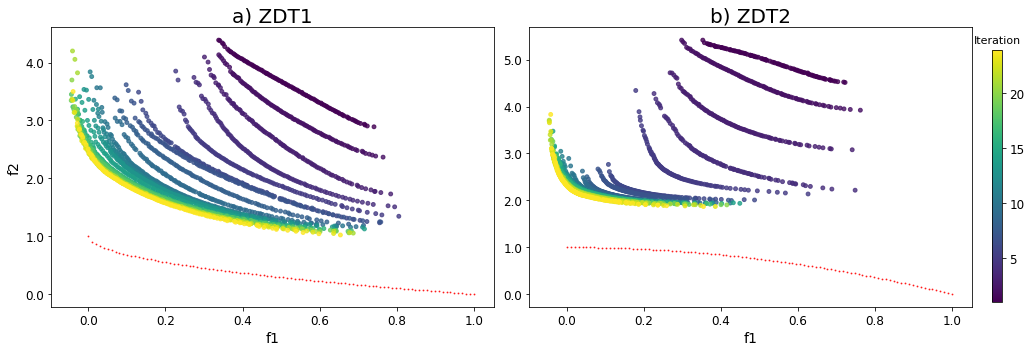

In [6]:
fig, ax = plt.subplots(ncols = 2, figsize = (14,5))
    
problem1 = get_problem("zdt1")
pareto = problem1.pareto_front()  
    
ax[0].scatter(pareto[:,0],
              pareto[:,1], 
              c="r", s=3, marker=".", alpha=0.8)

problemname = 'ZDT1'
qnehvi_plot = loadtxt(f'{problemname}_pf.csv', delimiter=',')
N_BATCH = 24
BATCH_SIZE = 8
batch_number = torch.arange(1, N_BATCH+1).repeat(100, 1).t().reshape(-1).numpy()

ax[0].scatter(qnehvi_plot[:,0],
              qnehvi_plot[:,1],
              c=batch_number, s=15, alpha=0.8)   

ax[0].set_title(f"a) {problemname}", fontsize=20)
ax[0].set_xlabel('f1')

###########

problem1 = get_problem("zdt2")
pareto = problem1.pareto_front()  
    
ax[1].scatter(pareto[:,0],
              pareto[:,1], 
              c="r", s=3, marker=".", alpha=0.8)

problemname = 'ZDT2'
qnehvi_plot = loadtxt(f'{problemname}_pf.csv', delimiter=',')
N_BATCH = 24
BATCH_SIZE = 8
batch_number = torch.arange(1, N_BATCH+1).repeat(100, 1).t().reshape(-1).numpy()

ax[1].scatter(qnehvi_plot[:,0],
              qnehvi_plot[:,1],
              c=batch_number, s=15, alpha=0.8)   

ax[1].set_title(f"b) {problemname}", fontsize=20)
ax[1].set_xlabel('f1')

#ax[i].set_xlim(-0.05, 1.125)
#ax[i].set_ylim(-0.2, 7.2)
    
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))    
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))    

    
fig.tight_layout()

ax[0].set_ylabel('f2')

norm = plt.Normalize(batch_number.min(), batch_number.max())
sm =  ScalarMappable(norm=norm, cmap=cm)
sm.set_array([])
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.97, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("Iteration", fontsize=11)

C:\Users\user\AppData\Local\Temp\ipykernel_70484\2793930540.py:3: DeprecationWarning: Call to deprecated function (or staticmethod) get_problem. (Please use `from pymoo.problems import get_problem
`)
  problem1 = get_problem("zdt3")
C:\Users\user\AppData\Local\Temp\ipykernel_70484\2793930540.py:28: DeprecationWarning: Call to deprecated function (or staticmethod) get_problem. (Please use `from pymoo.problems import get_problem
`)
  problem1 = get_problem("mw7")


Text(0.5, 1.0, 'Iteration')

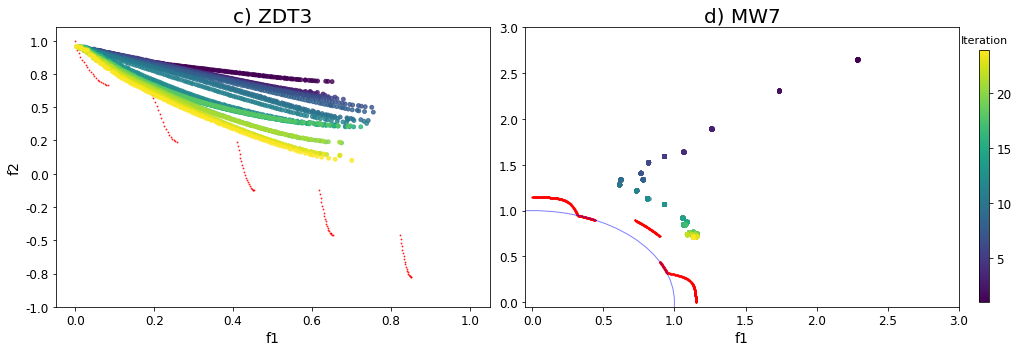

In [7]:
fig, ax = plt.subplots(ncols = 2, figsize = (14,5))
    
problem1 = get_problem("zdt3")
pareto = problem1.pareto_front()  
    
ax[0].scatter(pareto[:,0],
              pareto[:,1], 
              c="r", s=3, marker=".", alpha=0.8)

problemname = 'ZDT3'
qnehvi_plot = loadtxt(f'{problemname}_pf.csv', delimiter=',')
N_BATCH = 24
BATCH_SIZE = 8
batch_number = torch.arange(1, N_BATCH+1).repeat(100, 1).t().reshape(-1).numpy()

ax[0].scatter(qnehvi_plot[:,0],
              qnehvi_plot[:,1],
              c=batch_number, s=15, alpha=0.8)   

ax[0].set_title(f"c) {problemname}", fontsize=20)
ax[0].set_xlabel('f1')

ax[0].set_xlim(-0.05, 1.05)
ax[0].set_ylim(-1.0, 1.1)

###########

problem1 = get_problem("mw7")
pareto = problem1.pareto_front()  
    
ax[1].scatter(pareto[:,0],
              pareto[:,1], 
              c="r", s=3, marker=".", alpha=0.8)

problemname = 'MW7'
qnehvi_plot = loadtxt(f'{problemname}_pf.csv', delimiter=',')
N_BATCH = 24
BATCH_SIZE = 8
batch_number = torch.arange(1, N_BATCH+1).repeat(100, 1).t().reshape(-1).numpy()

ax[1].scatter(qnehvi_plot[:,0],
              qnehvi_plot[:,1],
              c=batch_number, s=15, alpha=0.8)   

ax[1].add_patch(plt.Circle((0, 0), 1, color='b', fill=False, alpha=0.5))

ax[1].set_title(f"d) {problemname}", fontsize=20)
ax[1].set_xlabel('f1')

ax[1].set_xlim(-0.05, 3)
ax[1].set_ylim(-0.05, 3)
    
fig.tight_layout()

ax[0].set_ylabel('f2')

ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))    
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))    

norm = plt.Normalize(batch_number.min(), batch_number.max())
sm =  ScalarMappable(norm=norm, cmap=cm)
sm.set_array([])
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.97, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("Iteration", fontsize=11)

Text(0.5, 1.0, 'Iteration')

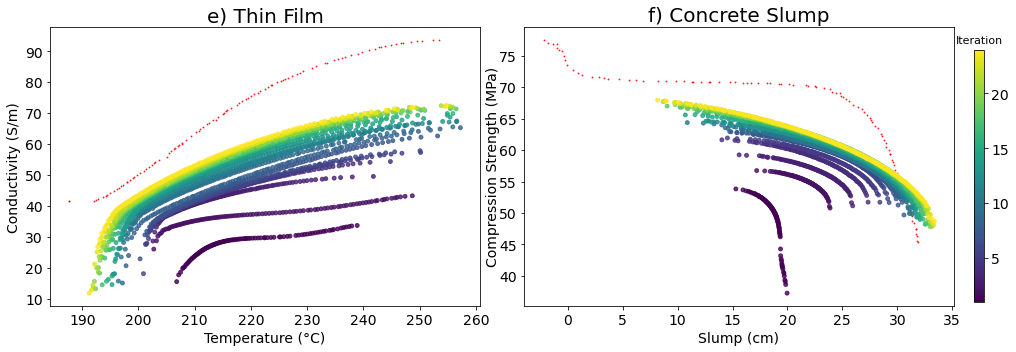

In [38]:
fig, ax = plt.subplots(ncols = 2, figsize = (14,5))
    
pareto_y1 = loadtxt('thinfilm_pareto1.csv',  delimiter=',')
pareto_y2 = loadtxt('thinfilm_pareto2.csv',  delimiter=',')

ax[0].scatter(pareto_y1,
              pareto_y2, 
              c="r", s=3, marker=".", alpha=0.8)

problemname = 'thinfilm'
qnehvi_plot = loadtxt(f'{problemname}_pf.csv', delimiter=',')
N_BATCH = 24
BATCH_SIZE = 8
batch_number = torch.arange(1, N_BATCH+1).repeat(100, 1).t().reshape(-1).numpy()

ax[0].scatter(qnehvi_plot[:,0],
              qnehvi_plot[:,1],
              c=batch_number, s=15, alpha=0.8)   

ax[0].set_title(f"e) Thin Film", fontsize=20)
ax[0].set_xlabel('Temperature (°C)', fontsize=14)

ax[0].set_ylabel('Conductivity (S/m)', fontsize=14)

#ax[0].set_xlim(-0.05, 1.05)
#ax[0].set_ylim(-1.0, 1.1)

###########

pareto = loadtxt("concrete_pareto.csv", delimiter=',')
    
ax[1].scatter(pareto[:,0],
              pareto[:,1], 
              c="r", s=3, marker=".", alpha=0.8)

problemname = 'concrete'
qnehvi_plot = loadtxt(f'{problemname}_pf.csv', delimiter=',')
N_BATCH = 24
BATCH_SIZE = 8
batch_number = torch.arange(1, N_BATCH+1).repeat(100, 1).t().reshape(-1).numpy()

ax[1].scatter(qnehvi_plot[:,0],
              qnehvi_plot[:,1],
              c=batch_number, s=15, alpha=0.8)   

ax[1].set_title(f"f) Concrete Slump", fontsize=20)
ax[1].set_xlabel('Slump (cm)', fontsize=14)

#ax[1].set_xlim(-0.05, 5)
#ax[1].set_ylim(-0.05, 5)
    
fig.tight_layout()

ax[1].set_ylabel('Compression Strength (MPa)', fontsize=14, labelpad=-1)

norm = plt.Normalize(batch_number.min(), batch_number.max())
sm =  ScalarMappable(norm=norm, cmap=cm)
sm.set_array([])
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.97, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("Iteration", fontsize=11)

C:\Users\user\AppData\Local\Temp\ipykernel_19492\666432609.py:3: DeprecationWarning: Call to deprecated function (or staticmethod) get_problem. (Please use `from pymoo.problems import get_problem
`)
  problem1 = get_problem("zdt1")
C:\Users\user\AppData\Local\Temp\ipykernel_19492\666432609.py:24: DeprecationWarning: Call to deprecated function (or staticmethod) get_problem. (Please use `from pymoo.problems import get_problem
`)
  problem1 = get_problem("zdt2")
C:\Users\user\AppData\Local\Temp\ipykernel_19492\666432609.py:46: DeprecationWarning: Call to deprecated function (or staticmethod) get_problem. (Please use `from pymoo.problems import get_problem
`)
  problem1 = get_problem("zdt3")


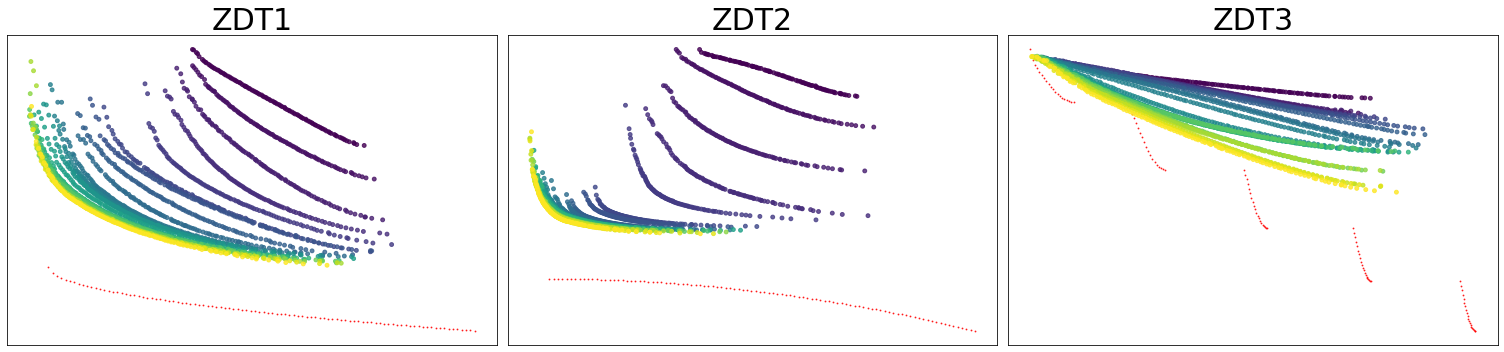

In [6]:
fig, ax = plt.subplots(ncols = 3, figsize = (21,5))
    
problem1 = get_problem("zdt1")
pareto = problem1.pareto_front()  
    
ax[0].scatter(pareto[:,0],
              pareto[:,1], 
              c="r", s=3, marker=".", alpha=0.8)

problemname = 'ZDT1'
qnehvi_plot = loadtxt(f'{problemname}_pf.csv', delimiter=',')
N_BATCH = 24
BATCH_SIZE = 8
batch_number = torch.arange(1, N_BATCH+1).repeat(100, 1).t().reshape(-1).numpy()

ax[0].scatter(qnehvi_plot[:,0],
              qnehvi_plot[:,1],
              c=batch_number, s=15, alpha=0.8)   

ax[0].set_title(f"{problemname}", fontsize=30)

###########

problem1 = get_problem("zdt2")
pareto = problem1.pareto_front()  
    
ax[1].scatter(pareto[:,0],
              pareto[:,1], 
              c="r", s=3, marker=".", alpha=0.8)

problemname = 'ZDT2'
qnehvi_plot = loadtxt(f'{problemname}_pf.csv', delimiter=',')
N_BATCH = 24
BATCH_SIZE = 8
batch_number = torch.arange(1, N_BATCH+1).repeat(100, 1).t().reshape(-1).numpy()

ax[1].scatter(qnehvi_plot[:,0],
              qnehvi_plot[:,1],
              c=batch_number, s=15, alpha=0.8)   

ax[1].set_title(f"{problemname}", fontsize=30)

    
fig.tight_layout()

problem1 = get_problem("zdt3")
pareto = problem1.pareto_front()  
    
ax[2].scatter(pareto[:,0],
              pareto[:,1], 
              c="r", s=3, marker=".", alpha=0.8)

problemname = 'ZDT3'
qnehvi_plot = loadtxt(f'{problemname}_pf.csv', delimiter=',')
N_BATCH = 24
BATCH_SIZE = 8
batch_number = torch.arange(1, N_BATCH+1).repeat(100, 1).t().reshape(-1).numpy()

ax[2].scatter(qnehvi_plot[:,0],
              qnehvi_plot[:,1],
              c=batch_number, s=15, alpha=0.8)   

ax[2].set_title(f"{problemname}", fontsize=30)
ax[2].set_xlabel('f1')

ax[2].set_ylabel('f2')


ax[0].set(ylabel=None, yticklabels=[], xlabel=None, xticklabels=[])
ax[0].tick_params(left=False, bottom=False)

ax[1].set(ylabel=None, yticklabels=[], xlabel=None, xticklabels=[])
ax[1].tick_params(left=False, bottom=False)

ax[2].set(ylabel=None, yticklabels=[], xlabel=None, xticklabels=[])
ax[2].tick_params(left=False, bottom=False)

fig.tight_layout()